# Data Preprocessing

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA

from datetime import datetime

import warnings

warnings.filterwarnings('ignore')

## Load the dataset

In [2]:
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')

df_origin = pd.read_csv('games-regression-dataset.csv', 
                        parse_dates=['Original Release Date' , 'Current Version Release Date'], 
                        date_parser=dateparse)

## Download the icons

In [ ]:
# Convert to string
df_origin['Icon URL'] = df_origin['Icon URL'].astype(str)

import requests
import os
import shutil


def download_image(url, filename):
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(filename, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)


# Create a folder to store the images
if not os.path.exists('icons'):
    os.makedirs('icons')

# Download the images
for i, row in df_origin.iterrows():
    download_image(row['Icon URL'], f'icons/{i}.png')

In [3]:
# Replace the URL with the icon filename which is the index of the row
df_origin['Icon URL'] = df_origin.apply(lambda row : f'icons/{row.name}.png', axis=1)

## Data Splitting

In [4]:
from sklearn.model_selection import train_test_split

df, df_test = train_test_split(df_origin, test_size=0.2, random_state=42)
df_test.to_csv('df_test.csv', index=False)

In [ ]:
df.shape

## Dropping unnecessary columns

In [5]:
# drop Primary Genre
df.drop(['Primary Genre', 'ID', 'URL'], axis=1, inplace=True)

## Justifications

### Primary Genre: it is mostly 'Game' (around 98% of the data has 'Game' as the primary genre). It is not useful for the model.
### ID: it is just an ID for the apple store database, not useful for the model.
### URL: it is the URL of the app in the apple store, not useful for the model.

## Dates preprocessing

In [6]:
## Convert the datetime to ordinal

df['Original Release Date'] = df['Original Release Date'].apply(lambda x: x.toordinal())
df['Current Version Release Date'] = df['Current Version Release Date'].apply(lambda x: x.toordinal())

# Get the median of the Original Release Date, Current Version Release Date after eliminating the outliers
median_original_release_date = df['Original Release Date'].median()
median_current_version_release_date = df['Current Version Release Date'].median()

# Create a new column with the age of the game
df['game_age'] = datetime.now().toordinal() - df['Original Release Date']

# Create a new column with the time since the last update
df['last_update'] = datetime.now().toordinal() - df['Current Version Release Date'] 

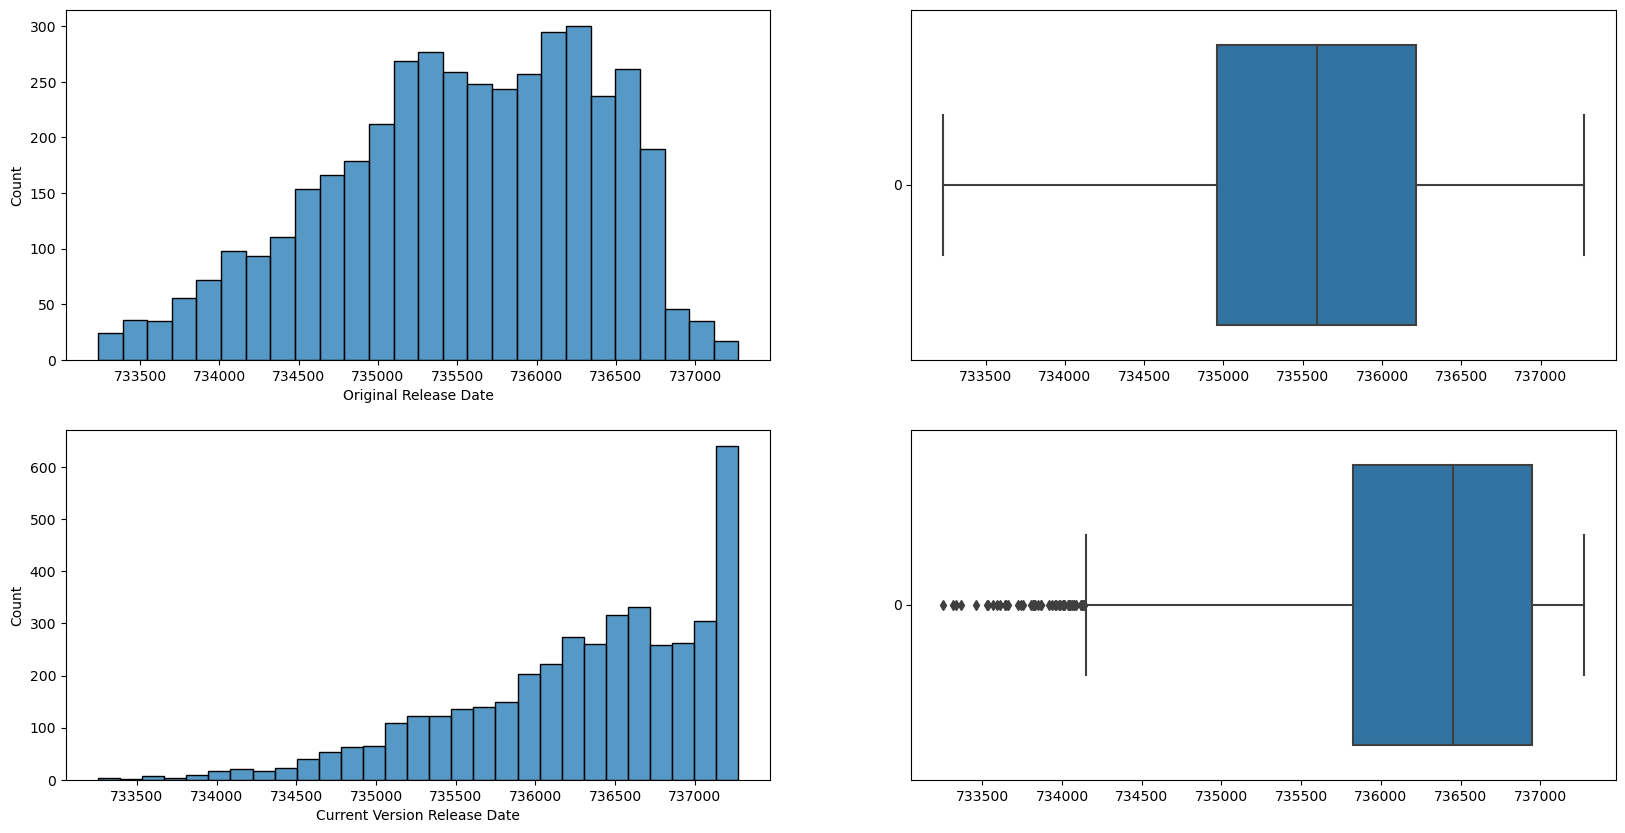

In [15]:
# Plot the distribution of the date columns

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.histplot(df['Original Release Date'], ax=ax[0, 0])

# boxplot of the Original Release Date
sns.boxplot(df['Original Release Date'], ax=ax[0, 1], orient='h')

sns.histplot(df['Current Version Release Date'], ax=ax[1, 0])

# boxplot of the Current Version Release Date
sns.boxplot(df['Current Version Release Date'], ax=ax[1, 1], orient='h')

plt.show()

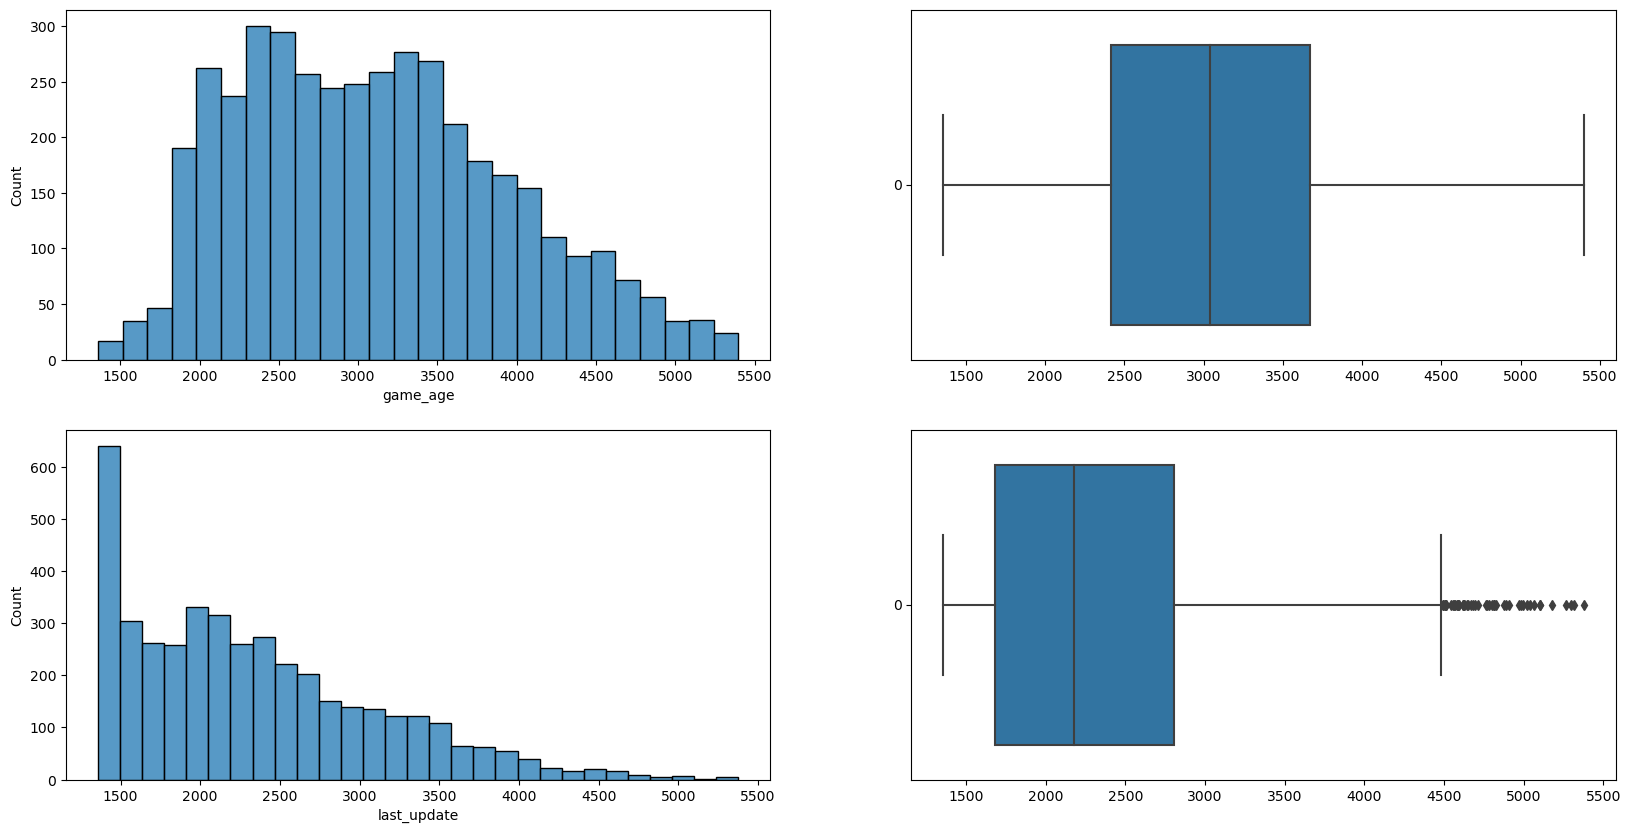

In [16]:
# Plot the distribution of the date columns

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.histplot(df['game_age'], ax=ax[0, 0])

# boxplot of the game age
sns.boxplot(df['game_age'], ax=ax[0, 1], orient='h')

sns.histplot(df['last_update'], ax=ax[1, 0])

# Create a boxplot of the game age feature
sns.boxplot(df['last_update'], ax=ax[1, 1], orient='h')

plt.show()

# Date outliers are legitimate data points that are worth keeping, they are not errors nor anomalies

## Data Exploration

### General information

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

### Genres

In [ ]:
df['Genres'] = df['Genres'].astype(str)
df['Genres'] = df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

genre_counts = df.explode('Genres').groupby('Genres').size().sort_values(ascending=False)
genre_counts


### Developer

In [6]:
df['Developer'].value_counts()

Tapps Tecnologia da Informa\xe7\xe3o Ltda.    79
EASY Inc.                                     24
Detention Apps                                22
HexWar Games Ltd                              21
Qumaron                                       17
                                              ..
Dennis Mengelt                                 1
Hopes                                          1
Christopher Brown                              1
Lothar Heinrich                                1
Koordinauten GmbH                              1
Name: Developer, Length: 2582, dtype: int64

In [7]:
df['Developer'].unique().size

2582

### Languages

In [ ]:
df['Languages'] = df['Languages'].astype(str)

df['Languages'] = df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

langs_counts = df.explode('Languages').groupby('Languages').size().sort_values(ascending=False)
print(langs_counts[1:30])

In [ ]:
df.hist(figsize=(15, 15))

## Developer preprocessing

In [17]:
# Convert to string
df['Developer'] = df['Developer'].astype(str)
df['Developer'] = df['Developer'].str.replace("'", "").str.strip('[]')

# Replace the developer names with less than 3 games with 'Other'
dev_counts = df['Developer'].value_counts()
other = dev_counts[dev_counts < 3].index
df['Developer'] = df['Developer'].replace(other, 'Other')

dev_df = df[['Developer', 'Average User Rating']].groupby('Developer').mean()

# Save dev_df to be used on the test set
dev_df.to_csv('encoders/dev_df.csv')

# Replace the developer names with the average user rating from dev_df
df['Developer'] = df['Developer'].replace(dev_df.index, dev_df['Average User Rating'])

## Genres preprocessing

### 1. NLP approach

In [ ]:
# Convert the genres column to a list of strings
df['Genres'] = df['Genres'].astype(str)
df['Genres'] = df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

# drop Games, Strategy, Entertainment from the Genres column
df['Genres'] = df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])

# Join the list of genres into a single string
genres = df['Genres'].apply(lambda x: ' '.join(x))

# Create a count Vectorizer and fit it to the genres
count_vec = CountVectorizer()
bow_genres = count_vec.fit_transform(genres)

# Apply principal component analysis to reduce the dimensionality
pca = PCA(n_components=10)
pca_genres = pca.fit_transform(bow_genres.toarray())

# Add the PCA-transformed genres to the original dataframe
for i in range(len(pca_genres[0])):
    df[f'Genre_PCA_{i}'] = pca_genres[:, i]

# Drop the original column
df = df.drop(['Genres'], axis=1)

### 2. Dummy variables approach

In [ ]:
# Convert the genres column to a list of strings
df['Genres'] = df['Genres'].astype(str)
df['Genres'] = df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

# drop Games, Strategy, Entertainment from the Genres column
df['Genres'] = df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])

# Replace genres with counts less than 100 with 'infrequent' as it would represent a very small percentage of the data (less than 2%)
other = df['Genres'].explode().value_counts()[df['Genres'].explode().value_counts() < 100].index
df['Genres'] = df['Genres'].apply(lambda x: [genre if genre not in other else 'infrequent' for genre in x])

# Get dummy variables for the genres
genres = pd.get_dummies(df['Genres'].apply(pd.Series).stack(), prefix="genre", dummy_na=False).sum(level=0)

# Save the genres dummies to be used on the test set
genres.to_csv('encoders/genres.csv', index=False)

# Add the dummy variables to the original dataframe
df = pd.concat([df, genres], axis=1)

# Drop the original column
df = df.drop(['Genres'], axis=1)

# Fill NaN with 0
genre_cols = [col for col in df.columns if col.startswith('genre')] # get all columns with prefix 'genre'
df[genre_cols] = df[genre_cols].fillna(0) # fill NaN with 0 for selected columns

### 3. Multi-label binarizer

In [ ]:
# Convert the genres column to a list of strings
df['Genres'] = df['Genres'].astype(str)
df['Genres'] = df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

# drop Games, Strategy, Entertainment from the Genres column
df['Genres'] = df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])

# Replace genres with counts less than 100 with 'infrequent' as it would represent a very small percentage of the data (less than 2%)
other = df['Genres'].explode().value_counts()[df['Genres'].explode().value_counts() < 100].index
df['Genres'] = df['Genres'].apply(lambda x: [genre if genre not in other else 'infrequent_genre' for genre in x])

# Instantiate the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit the MultiLabelBinarizer to the genres
mlb.fit(df['Genres'])

# Drop nan from the classes
mlb.classes_ = np.delete(mlb.classes_, np.where(mlb.classes_ == 'nan'))

# Save the mlb for later use with the test data
pickle.dump(mlb, open('encoders/mlb_genres.pkl', 'wb'))

# Transform the genres into a one-hot encoded array
genres_mlb = mlb.transform(df['Genres'])

# Create a dataframe from the one-hot encoded array
genres_mlb_df = pd.DataFrame(genres_mlb, columns=mlb.classes_)

# Add the one-hot encoded genres to the original dataframe
df = pd.concat([df, genres_mlb_df], axis=1)

# Drop the original column
df = df.drop(['Genres'], axis=1)

## Languages preprocessing

### 1. NLP approach

In [ ]:
# Convert the langs column to a list of strings
df['Languages'] = df['Languages'].astype(str)
df['Languages'] = df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

# Drop the English language from the Languages column
df['Languages'] = df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])

# Join the list of langs into a single string
languages = df['Languages'].apply(lambda x: ' '.join(x))

# Create a count Vectorizer and fit it to the langs
count_vec = CountVectorizer()
bow_languages = count_vec.fit_transform(languages)

# Apply principal component analysis to reduce the dimensionality
pca = PCA(n_components=10)
pca_languages = pca.fit_transform(bow_languages.toarray())

# Add the PCA-transformed langs to the original dataframe
for i in range(len(pca_languages[0])):
    df[f'Languages_PCA_{i}'] = pca_languages[:, i]

# Drop the original column
df = df.drop(['Languages'], axis=1)

print(df.shape)

df.iloc[:, 15:].head()

### 2. Dummy variables approach

In [ ]:
# Convert the langs column to a list of strings
df['Languages'] = df['Languages'].astype(str)
df['Languages'] = df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

# Create a column with the number of languages supported
df['langs_count'] = df['Languages'].apply(lambda x: len(x))

# Drop the English language from the Languages column (it is the most common language and would dominate the model)
df['Languages'] = df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])

# Replace langs with counts less than 500 with 'infrequent_langs' as it would represent a very small percentage of the data (less than 10%)
other = df['Languages'].explode().value_counts()[df['Languages'].explode().value_counts() < 500].index
df['Languages'] = df['Languages'].apply(lambda x: [lang if lang not in other else 'infrequent' for lang in x])

# Get dummy variables for the langs
langs = pd.get_dummies(df['Languages'].apply(pd.Series).stack(), prefix='lang', dummy_na=False).sum(level=0)

langs.to_csv('encoders/langs.csv', index=False)

# Add the dummy variables to the original dataframe
df = pd.concat([df, langs], axis=1)

# Drop the original column
df = df.drop(['Languages'], axis=1)

# Fill NaN with 0
lang_cols = [col for col in df.columns if col.startswith('lang')] # get all columns with prefix 'lang'
df[lang_cols] = df[lang_cols].fillna(0) # fill NaN with 0 for selected columns

### 3. Multi-label binarizer

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Convert the langs column to a list of strings
df['Languages'] = df['Languages'].astype(str)
df['Languages'] = df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

# Create a column with the number of languages supported
df['langs_count'] = df['Languages'].apply(lambda x: len(x))

# Drop the English language from the Languages column (it is the most common language and would dominate the model)
df['Languages'] = df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])

# Replace langs with counts less than 500 with 'infrequent_langs' as it would represent a very small percentage of the data (less than 10%)
other = df['Languages'].explode().value_counts()[df['Languages'].explode().value_counts() < 400].index
df['Languages'] = df['Languages'].apply(lambda x: [lang if lang not in other else 'infrequent_lang' for lang in x])

# Instantiate the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit the MultiLabelBinarizer to the langs
mlb.fit(df['Languages'])

# Drop nan from the classes
mlb.classes_ = np.delete(mlb.classes_, np.where(mlb.classes_ == 'nan'))

# Save the mlb for later use with the test data
pickle.dump(mlb, open('encoders/mlb_langs.pkl', 'wb'))

# Transform the langs into a one-hot encoded array
langs_mlb = mlb.transform(df['Languages'])

# Create a dataframe from the one-hot encoded array
langs_mlb_df = pd.DataFrame(langs_mlb, columns=mlb.classes_)

# Add the encoded langs to the original dataframe
df = pd.concat([df, langs_mlb_df], axis=1)

# Drop the original column
df = df.drop(['Languages'], axis=1)

## In-app Purchases preprocessing

In [ ]:
# Free apps might skew the in-app purchases column,
# so we might split the dataset into free and paid apps

df['In-app Purchases'] = df['In-app Purchases'].astype(str)
df['In-app Purchases'] = df['In-app Purchases'].str.strip('[]').str.replace("'", "").str.split(", ")

# Convert to float
df['In-app Purchases'] = df['In-app Purchases'].apply(lambda x: [float(i) for i in x])

# Get the number of in-app purchases
df['purchases_count'] = df['In-app Purchases'].apply(lambda x: len(x))

# Get the lowest, highest and average purchase
df['lowest_purchase'] = df['In-app Purchases'].apply(lambda x: min(x) if len(x) > 0 else 0)
df['highest_purchase'] = df['In-app Purchases'].apply(lambda x: max(x) if len(x) > 0 else 0)
df['average_purchase'] = df['In-app Purchases'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)

# Drop the original column
df = df.drop(['In-app Purchases'], axis=1)

df['lowest_purchase'] = df['lowest_purchase'].fillna(0)
df['highest_purchase'] = df['highest_purchase'].fillna(0)
df['average_purchase'] = df['average_purchase'].fillna(0)

## Age Rating preprocessing

In [ ]:
# Convert to string
df['Age Rating'] = df['Age Rating'].astype(str)

# Remove the + sign
df['Age Rating'] = df['Age Rating'].str.replace('+', '')

# Convert to int
df['Age Rating'] = df['Age Rating'].astype(float)

## NLP preprocessing

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from textblob import TextBlob
import re

def preprocess_nlp(col):
    df[col] = df[col].astype(str)

    # Remove URLs and email addresses
    df[col] = df[col].apply(lambda x: re.sub(r'http\S+|www.\S+|\S+@\S+', '', x))

    # Remove the punctuation, numbers, and convert to lowercase
    df[col] = df[col].apply(lambda x: " ".join(re.findall(r'\w+', x.lower())))

    # Remove the stopwords
    stop = stopwords.words('english')
    df[col] = df[col].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

    # Stemming
    st = nltk.PorterStemmer()
    df[col] = df[col].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

    # Lemmatization
    lem = nltk.WordNetLemmatizer()
    df[col] = df[col].apply(lambda x: " ".join([lem.lemmatize(word) for word in x.split()]))

    # Remove the frequent and rare words
    freq = pd.Series(' '.join(df[col]).split()).value_counts()
    common_freq = list(freq[:10].index)
    rare_freq = list(freq[-10:].index)
    df[col] = df[col].apply(lambda x: " ".join(x for x in x.split() if x not in common_freq+rare_freq))

    # Remove the whitespaces
    df[col] = df[col].apply(lambda x: " ".join(x.strip() for x in x.split()))

    # Replace NaN values with empty string
    df[col] = df[col].fillna('')

    # Convert text data to bag-of-words representation
    vectorizer = CountVectorizer()
    BoW = vectorizer.fit_transform(df[col])

    # Apply principal component analysis to reduce the dimensionality
    pca_ = PCA(n_components=2)
    pca_col = pca_.fit_transform(BoW.toarray())
    
    # Save the vectorizer and pca for later use with the test data
    pickle.dump(vectorizer, open(f'encoders/vectorizer_{col}.pkl', 'wb'))
    pickle.dump(pca_, open(f'encoders/pca_{col}.pkl', 'wb'))

    # Add the PCA-transformed col to the original dataframe
    for feat in range(len(pca_col[0])):
        df[f'{col}_PCA_{feat}'] = pca_col[:, feat]



In [ ]:
preprocess_nlp('Description')
preprocess_nlp('Subtitle')
preprocess_nlp('Name')

df = df.drop(['Description', 'Subtitle', 'Name'], axis=1)

## Icon preprocessing

### Extract features from the icons

In [ ]:
import cv2

def preprocess_icon(img_path):
    # Load the game icon image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (100, 100))

    # Extract color features using color histograms
    colors = ('b', 'g', 'r')
    color_features = []
    for k, col in enumerate(colors):
        hist = cv2.calcHist([img], [k], None, [256], [0, 256])
        color_features.append(hist)

    # Reshape the color features to have a single dimension
    color_features = np.concatenate(color_features).ravel()

    # Extract shape features using edge detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_features = np.array(edges).flatten()

    # Combine the color and shape features into a single feature vector
    feature_vector = np.concatenate((color_features, edge_features))

    # Normalize the feature vector to have unit length
    normalized_feature_vector = feature_vector / np.linalg.norm(feature_vector)
    
    return normalized_feature_vector


In [ ]:
from tqdm import tqdm

# Create a list to store the feature vectors
icon_features = []

df['Icon URL'] = df['Icon URL'].astype(str)

# Iterate over the images and extract the features
for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    feature_vec = preprocess_icon(row['Icon URL'])
    icon_features.append((row['Icon URL'], feature_vec))
    
# Apply PCA to reduce the number of features
pca = PCA(n_components=4)
pca.fit([f[1] for f in icon_features])
reduced_features = pca.transform([f[1] for f in icon_features])

# Save the pca instance for later use
pickle.dump(pca, open('encoders/icon_pca.pkl', 'wb'))

# Convert the reduced features to a dataframe
icon_features_df = pd.DataFrame({'Icon URL': [f[0] for f in icon_features],
                                    'Icon1': reduced_features[:,0],
                                    'Icon2': reduced_features[:,1],
                                    'Icon3': reduced_features[:,2],
                                    'Icon4': reduced_features[:,3]})

### Add the icon features to the dataset

In [ ]:
# Merge the icon features with the original dataframe on the icon URL
df = df.merge(icon_features_df, on='Icon URL', how='left')

# Drop the icon URL column
df = df.drop(['Icon URL'], axis=1)

In [ ]:
# Save the preprocessed data
df.to_csv('preprocessed_data.csv', index=False)

## Scaling and Model Training

In [ ]:
df = pd.read_csv('preprocessed_data.csv')

In [ ]:
from scipy import stats

# Calculate Z-scores for each data point
z_scores = np.abs(stats.zscore(df))

# Define a threshold to identify an outlier
threshold = 3

# Get a list of row numbers which are outliers
outlier_rows = np.where(z_scores > threshold)[0]

print(f'Number of outliers: {len(outlier_rows)}')

# Replace the outliers with the mean
mean_values = np.mean(df[~((z_scores > threshold).any(axis=1))], axis=0)
df[~((z_scores > threshold).any(axis=1))] = df[~((z_scores > threshold).any(axis=1))].fillna(mean_values)


In [ ]:
df_x = df.drop(['Average User Rating'], axis=1)
df_y = df['Average User Rating']

In [ ]:
df_x.shape

### Feature Scaling

In [ ]:
# print only the columns with nan values and their count
print(df_x.isnull().sum()[df_x.isnull().sum() > 0])

In [ ]:
# Scale the features
from sklearn.preprocessing import StandardScaler

cols = df_x.columns

scaler = StandardScaler()
df_x = scaler.fit_transform(df_x)

df_x = pd.DataFrame(df_x, columns=cols)

# Save the scaler
pickle.dump(scaler, open('scalers/std_scaler.pkl', 'wb'))

df_x.plot()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

cols = df_x.columns

scaler = MinMaxScaler()
df_x = scaler.fit_transform(df_x)

df_x = pd.DataFrame(df_x, columns=cols)

# Save the scaler
pickle.dump(scaler, open('scalers/min_max_scaler.pkl', 'wb'))

df_x.hist(figsize=(15, 15))

In [ ]:
# plot correlation matrix between features and target
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_x.corrwith(df_y)
corr = corr.sort_values(ascending=False)
plt.figure(figsize=(10, 10))
sns.barplot(x=corr.values, y=corr.index)
plt.show()

### Feature Selection

In [ ]:
# Feature selection
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=10)
df_x_select =  selector.fit_transform(df_x, df_y)

# Save the selector
pickle.dump(selector, open('encoders/selector.pkl', 'wb'))

In [ ]:
# Print the selected features
for i in range(len(selector.get_support())): 
    if selector.get_support()[i]:
        print(df_x.columns[i])

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(df_x_select, df_y)

# Print the training MSE and R2 score
print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/LR_model.pkl', 'wb'))



### Ridge Regression

In [ ]:
# Create a ridge regression model
model = Ridge(alpha=20)

# Train the model
model.fit(df_x_select, df_y)

# Print the training MSE and R2 score
print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/Ridge_model.pkl', 'wb'))


### Lasso Regression

In [ ]:
# Create a lasso regression model
model = Lasso(alpha=0.001)

# Train the model
model.fit(df_x_select, df_y)

print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/Lasso_model.pkl', 'wb'))


### Elastic Net Regression

In [ ]:
# Create an elastic net regression model
model = ElasticNet(alpha=0.001)

# Train the model
model.fit(df_x_select, df_y)

print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/ElasticNet_model.pkl', 'wb'))


### Polynomial Regression

In [ ]:
# Create a polynomial regression model
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(df_x_select)

# Save the polynomial features
pickle.dump(poly, open('encoders/poly.pkl', 'wb'))

# Train the model
model = LinearRegression()
model.fit(X_train_poly, df_y)

print('Training MSE: ', mean_squared_error(df_y, model.predict(X_train_poly)))
print('Training R2: ', r2_score(df_y, model.predict(X_train_poly)))

# Save the model
pickle.dump(model, open('models/Polynomial_model.pkl', 'wb'))


### XGBoost

In [ ]:
# Create an XGBoost model

import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, max_depth=3)
model.fit(df_x_select, df_y)

print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/XGBoost_model.pkl', 'wb'))

### Gradient Boosting

In [ ]:
# Create a Gradient Boosting model

from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(learning_rate=0.11)

# Train the model
model.fit(df_x_select, df_y)

# Print the training MSE and R2 score
print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/GradientBoosting_model.pkl', 'wb'))

### Random Forest Regression

In [ ]:
# Create a Random Forest Regressor model

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=7)

# Train the model
model.fit(df_x_select, df_y)

# Print the training MSE and R2 score
print('Training MSE: ', mean_squared_error(df_y, model.predict(df_x_select)))
print('Training R2: ', r2_score(df_y, model.predict(df_x_select)))

# Save the model
pickle.dump(model, open('models/RandomForest_model.pkl', 'wb'))